
# Create `dengue_month_complete_2005_2024.csv`

This notebook reproduces the full workflow:

1. **Load** the raw dataset `dataset_dengue_2005_2024.csv`.
2. **Extract** original monthly records.
3. **Aggregate** weekly records to monthly totals.
4. **Merge** both sources into one complete monthly dataset (2005‑2024).
5. **Export** the merged file and quick‑preview the result.


In [1]:
# --- Data Quality Check
# Chạy script kiểm tra các vấn đề bất thường trong dataset
import subprocess
import sys

print("=" * 80)
print("KIỂM TRA CHẤT LƯỢNG DỮ LIỆU")
print("=" * 80)
print("\nĐang chạy script kiểm tra...\n")

try:
    result = subprocess.run(
        [sys.executable, 'check_data_anomalies.py'],
        capture_output=True,
        text=True,
        encoding='utf-8',
        errors='replace'
    )
    
    if result.returncode == 0:
        print(result.stdout)
    else:
        print("Lỗi khi chạy script:")
        print(result.stderr)
except Exception as e:
    print(f"Không thể chạy script: {e}")
    print("\nBạn có thể chạy thủ công bằng lệnh:")
    print("  python check_data_anomalies.py")
    print("\nHoặc xem báo cáo chi tiết trong file:")
    print("  BAO_CAO_KIEM_TRA_DU_LIEU.md")

print("\n" + "=" * 80)


KIỂM TRA CHẤT LƯỢNG DỮ LIỆU

Đang chạy script kiểm tra...

Lỗi khi chạy script:
c:\Users\Pht Technology\AppData\Local\Programs\Python\Python312\python.exe: can't open file 'c:\\Users\\Pht Technology\\Downloads\\Compressed\\SGU25_MHHTH-main\\SGU25_MHHTH-main\\Dataset Processing\\check_data_anomalies.py': [Errno 2] No such file or directory




In [2]:
import pandas as pd
from pathlib import Path

RAW_PATH = Path('dataset_dengue_2005_2024.csv')
OUTPUT_PATH = Path('dengue_month_complete_2005_2024.csv')

df = pd.read_csv(RAW_PATH)
df['calendar_start_date'] = pd.to_datetime(df['calendar_start_date'], errors='coerce')
df['T_res'] = df['T_res'].str.strip().str.lower()

print(f"Raw rows: {len(df):,}")
df.head()


Raw rows: 4,939


,adm_0_name,adm_1_name,adm_2_name,full_name,ISO_A0,FAO_GAUL_code,RNE_iso_code,IBGE_code,calendar_start_date,calendar_end_date,Year,dengue_total,case_definition_standardised,S_res,T_res,UUID,region
0,VIET NAM,NAM DINH,NaN,"VIET NAM, NAM DINH",VNM,1012329,VN-67,NaN,2005-01-01,1/31/2005,2005,0,Total,Admin1,month,TYCHO-ALL-19242017-SV_DF01-00,WPRO
1,VIET NAM,BA RIA-VUNG TAU,NaN,"VIET NAM, BA RIA-VUNG TAU",VNM,1012369,VN-43,NaN,2005-01-01,1/31/2005,2005,4,Total,Admin1,month,TYCHO-ALL-19242017-SV_DF01-00,WPRO
2,VIET NAM,BAC GIANG,NaN,"VIET NAM, BAC GIANG",VNM,1012309,VN-54,NaN,2005-01-01,1/31/2005,2005,0,Total,Admin1,month,TYCHO-ALL-19242017-SV_DF01-00,WPRO
3,VIET NAM,DA NANG CITY,NaN,"VIET NAM, DA NANG CITY",VNM,1012301,VN-DN,NaN,2005-01-01,1/31/2005,2005,0,Total,Admin1,month,TYCHO-ALL-19242017-SV_DF01-00,WPRO
4,VIET NAM,DIEN BIEN,NaN,"VIET NAM, DIEN BIEN",VNM,1012316,VN-71,NaN,2005-01-01,1/31/2005,2005,0,Total,Admin1,month,TYCHO-ALL-19242017-SV_DF01-00,WPRO


In [3]:
# --- Extract original Month rows
df_month = df[df['T_res'] == 'month'].copy()
df_month['adm_1_name'] = df_month['adm_1_name'].fillna('National')
df_month['Year'] = df_month['calendar_start_date'].dt.year
df_month['Month'] = df_month['calendar_start_date'].dt.month
df_month['YearMonth'] = df_month['calendar_start_date'].dt.to_period('M').dt.to_timestamp()

month_summary = (
    df_month
    .groupby(['adm_1_name', 'Year', 'Month', 'YearMonth'], as_index=False)['dengue_total']
    .sum()
    .rename(columns={'dengue_total': 'dengue_total_month'})
)
print("Original Month summary shape:", month_summary.shape)
month_summary.head()


Original Month summary shape: (4642, 5)


,adm_1_name,Year,Month,YearMonth,dengue_total_month
0,AN GIANG,2005,1,2005-01-01,257
1,AN GIANG,2005,2,2005-02-01,107
2,AN GIANG,2005,3,2005-03-01,143
3,AN GIANG,2005,4,2005-04-01,231
4,AN GIANG,2005,5,2005-05-01,180


In [4]:
# --- Aggregate Week → Month
# Chỉ dùng Week data nếu tháng có >= 3 weeks (75% tháng) để đảm bảo độ tin cậy
MIN_WEEKS_THRESHOLD = 3  # Ngưỡng tối thiểu: 3 weeks = 75% tháng

df_week = df[df['T_res'] == 'week'].copy()
df_week['Year'] = df_week['calendar_start_date'].dt.year
df_week['Month'] = df_week['calendar_start_date'].dt.month
df_week['YearMonth'] = df_week['calendar_start_date'].dt.to_period('M').dt.to_timestamp()
df_week['adm_1_name'] = df_week['adm_1_name'].fillna('National')

# Aggregate và đếm số weeks trong mỗi tháng
week_agg = (
    df_week
    .groupby(['adm_1_name', 'Year', 'Month', 'YearMonth'], as_index=False)
    .agg({
        'dengue_total': ['sum', 'count']  # sum cases, count weeks
    })
)
week_agg.columns = ['adm_1_name', 'Year', 'Month', 'YearMonth', 'dengue_total_month', 'week_count']

# Chỉ giữ các tháng có >= 3 weeks
week_agg_before_filter = len(week_agg)
week_agg = week_agg[week_agg['week_count'] >= MIN_WEEKS_THRESHOLD].copy()
week_agg_filtered = week_agg_before_filter - len(week_agg)

print(f"Week aggregated shape: {week_agg.shape}")
if week_agg_filtered > 0:
    print(f"⚠ Filtered out {week_agg_filtered} months with < {MIN_WEEKS_THRESHOLD} weeks")
    print(f"  (These months will use Year distribution instead)")
    print(f"  Kept {len(week_agg)} months with >= {MIN_WEEKS_THRESHOLD} weeks")
else:
    print(f"✓ All months have >= {MIN_WEEKS_THRESHOLD} weeks")

# Hiển thị thống kê số weeks
if len(week_agg) > 0:
    print(f"\nWeek count statistics:")
    print(f"  Min weeks: {week_agg['week_count'].min()}")
    print(f"  Max weeks: {week_agg['week_count'].max()}")
    print(f"  Mean weeks: {week_agg['week_count'].mean():.2f}")
    print(f"  Months with 3 weeks: {(week_agg['week_count'] == 3).sum()}")
    print(f"  Months with 4 weeks: {(week_agg['week_count'] >= 4).sum()}")

week_agg.head()


Week aggregated shape: (63, 6)
⚠ Filtered out 9 months with < 3 weeks
  (These months will use Year distribution instead)
  Kept 63 months with >= 3 weeks

Week count statistics:
  Min weeks: 3
  Max weeks: 5
  Mean weeks: 4.25
  Months with 3 weeks: 3
  Months with 4 weeks: 60


,adm_1_name,Year,Month,YearMonth,dengue_total_month,week_count
0,National,2016,1,2016-01-01,12649,5
1,National,2016,2,2016-02-01,5880,4
2,National,2016,3,2016-03-01,4155,4
3,National,2016,4,2016-04-01,4232,4
4,National,2016,5,2016-05-01,5868,5


In [5]:
# --- Extract Year records và distribute vào monthly (2020-2022)
# Year records chứa annual totals, cần distribute vào 12 tháng dựa trên seasonal pattern

df_year = df[df['T_res'] == 'year'].copy()
df_year['adm_1_name'] = df_year['adm_1_name'].fillna('National')
df_year['Year'] = df_year['calendar_start_date'].dt.year

print(f"Year records found: {len(df_year)}")
if len(df_year) > 0:
    print("\nYear records:")
    print(df_year[['Year', 'dengue_total', 'adm_1_name']].to_string())
    
    # Tính seasonal pattern từ historical data (2005-2019)
    # Sử dụng dữ liệu trước COVID để có pattern ổn định hơn (15 năm thay vì 5 năm)
    # Cơ sở: Dengue có chu kỳ 2-3 năm, nên 2005-2019 cung cấp pattern bền vững hơn
    historical_combined = pd.concat([month_summary, week_agg], ignore_index=True)
    historical_national = historical_combined[
        (historical_combined['adm_1_name'] == 'National') &
        (historical_combined['Year'] >= 2005) &
        (historical_combined['Year'] <= 2019)
    ]
    
    if len(historical_national) > 0:
        # Tính monthly average và weights từ toàn bộ dữ liệu pre-COVID
        monthly_avg = historical_national.groupby('Month')['dengue_total_month'].mean()
        monthly_weights = monthly_avg / monthly_avg.sum()
        
        print("\nMonthly seasonal pattern (weights from 2005-2019: 15 years of pre-COVID data):")
        print(f"  Data range: {historical_national['Year'].min()}-{historical_national['Year'].max()}")
        print(f"  Number of observations: {len(historical_national)} months")
        print(f"  Rationale: Dengue has 2-3 year cycles, using 15 years provides stable pattern")
        for month, weight in monthly_weights.items():
            print(f"  Month {month:2d}: {weight:.4f} ({weight*100:.2f}%)")
        
        # Check which months already have Month or Week data (to avoid double-counting)
        # Priority: Month > Week > Year
        # Nếu tháng đó đã có Month hoặc Week data, không distribute Year data cho tháng đó
        existing_months = set()
        
        # Check Month data
        if len(month_summary) > 0:
            month_national = month_summary[month_summary['adm_1_name'] == 'National']
            for _, month_row in month_national.iterrows():
                year_month_key = (int(month_row['Year']), int(month_row['Month']))
                existing_months.add(year_month_key)
        
        # Check Week data (chỉ các tháng có >= 3 weeks đã được filter ở Cell 4)
        if len(week_agg) > 0:
            week_national = week_agg[week_agg['adm_1_name'] == 'National']
            for _, week_row in week_national.iterrows():
                year_month_key = (int(week_row['Year']), int(week_row['Month']))
                existing_months.add(year_month_key)
            
            # Thống kê Week data
            week_months_count = len(week_national)
            if week_months_count > 0:
                print(f"\n✓ Week data available: {week_months_count} months (all have >= 3 weeks)")
                print(f"  These months will use Week data instead of Year distribution")
        
        if len(existing_months) > 0:
            print(f"\n⚠ Found {len(existing_months)} months with existing Month/Week data")
            print("  These months will use Month/Week data instead of Year distribution")
            print(f"  (Priority: Month > Week > Year)")
            print(f"  Note: Week data only used if month has >= 3 weeks (75% of month)")
        
        # Distribute annual totals vào monthly
        year_monthly_list = []
        for _, row in df_year.iterrows():
            year = int(row['Year'])
            annual_total = float(row['dengue_total'])
            adm_name = row['adm_1_name']
            
            # Check Month data cho năm này
            year_month_data = month_summary[
                (month_summary['adm_1_name'] == adm_name) & 
                (month_summary['Year'] == year)
            ]
            month_total_for_year = year_month_data['dengue_total_month'].sum() if len(year_month_data) > 0 else 0.0
            month_count = len(year_month_data)
            
            # Check Week data cho năm này (chỉ các tháng có >= 3 weeks)
            year_week_data = week_agg[
                (week_agg['adm_1_name'] == adm_name) & 
                (week_agg['Year'] == year)
            ]
            week_total_for_year = year_week_data['dengue_total_month'].sum() if len(year_week_data) > 0 else 0.0
            week_count = len(year_week_data)  # Số tháng có Week data (>= 3 weeks)
            
            # Tính tổng số weeks thực tế (nếu cần)
            if len(year_week_data) > 0 and 'week_count' in year_week_data.columns:
                total_weeks = year_week_data['week_count'].sum()
            else:
                total_weeks = 0
            
            # Nếu năm đã có đầy đủ Month data (12 tháng), skip Year record
            if month_count >= 12:
                print(f"\n✓ Year {year}: Has complete Month data ({month_count} months, Total: {month_total_for_year:,.0f})")
                print(f"  Skipping Year record distribution (Priority: Month > Year)")
                continue
            
            # Nếu có Week data đầy đủ (>= 12 tháng, mỗi tháng có >= 3 weeks), ưu tiên Week data thay vì Year record
            # Đặc biệt xử lý 2016: Week total (109,649) > Year total (91,609)
            # week_count = số tháng có Week data (>= 3 weeks mỗi tháng)
            if week_count >= 12:
                if week_total_for_year > annual_total:
                    print(f"\n⚠ Year {year}: Week data ({week_count} months, {total_weeks} weeks, Total: {week_total_for_year:,.0f}) > Year total ({annual_total:,.0f})")
                    print(f"  Data inconsistency detected. Skipping Year record, using Week data instead (Priority: Week > Year).")
                else:
                    print(f"\n✓ Year {year}: Has complete Week data ({week_count} months, {total_weeks} weeks, Total: {week_total_for_year:,.0f})")
                    print(f"  Skipping Year record distribution (Priority: Week > Year)")
                    print(f"  (All months have >= 3 weeks)")
                continue
            
            # Tính tổng Month + Week data để trừ khỏi annual total
            existing_total = month_total_for_year + week_total_for_year
            
            # Annual total cần distribute = annual_total - existing_total (tránh double-counting)
            annual_to_distribute = annual_total - existing_total
            
            if annual_to_distribute < 0:
                print(f"\n⚠ Warning: Year {year} - Existing data total ({existing_total:,.0f}) > Annual total ({annual_total:,.0f})")
                print(f"  Month: {month_total_for_year:,.0f} ({month_count} months)")
                if week_total_for_year > 0:
                    print(f"  Week: {week_total_for_year:,.0f} ({week_count} months with >= 3 weeks, {total_weeks} weeks total)")
                else:
                    print(f"  Week: {week_total_for_year:,.0f} ({week_count} months)")
                print(f"  This suggests data inconsistency. Skipping Year record distribution.")
                continue
            
            # Tính tổng weight cho các tháng không có Month/Week data
            months_without_data = [m for m in range(1, 13) if (year, m) not in existing_months]
            if len(months_without_data) > 0:
                # Redistribute annual_to_distribute chỉ cho các tháng không có Month/Week data
                total_weight_without_data = sum(monthly_weights[m] for m in months_without_data)
                # Scale weights để tổng = 1 cho các tháng còn lại
                adjusted_weights = {m: monthly_weights[m] / total_weight_without_data 
                                   for m in months_without_data}
            else:
                # Tất cả tháng đều có Month/Week data, không cần distribute
                adjusted_weights = {}
            
            for month in range(1, 13):
                yearmonth = pd.Timestamp(f'{year}-{month:02d}-01')
                
                # Nếu tháng này đã có Month/Week data, skip (không distribute Year data)
                if (year, month) in existing_months:
                    continue
                
                # Distribute dựa trên adjusted weights
                if month in adjusted_weights:
                    monthly_value = annual_to_distribute * adjusted_weights[month]
                else:
                    # Fallback: uniform distribution
                    monthly_value = annual_to_distribute / len(months_without_data) if len(months_without_data) > 0 else 0
                
                year_monthly_list.append({
                    'adm_1_name': adm_name,
                    'Year': year,
                    'Month': month,
                    'YearMonth': yearmonth,
                    'dengue_total_month': monthly_value
                })
            
            # Validation message
            if week_total_for_year > 0 or month_total_for_year > 0:
                distributed_sum = sum([item['dengue_total_month'] for item in year_monthly_list 
                                      if item['Year'] == year])
                expected_sum = annual_total
                actual_sum = distributed_sum + week_total_for_year + month_total_for_year
                print(f"\n  Year {year} validation:")
                print(f"    Annual total: {annual_total:,.0f}")
                if month_total_for_year > 0:
                    print(f"    Month data: {month_total_for_year:,.0f} ({month_count} months)")
                if week_total_for_year > 0:
                    print(f"    Week data: {week_total_for_year:,.0f} ({week_count} months, {total_weeks} weeks total)")
                    print(f"      (Only months with >= 3 weeks are used)")
                print(f"    Distributed to {len(months_without_data)} months: {distributed_sum:,.2f}")
                print(f"    Total (distributed + existing): {actual_sum:,.2f}")
                if abs(actual_sum - expected_sum) > 0.01:
                    print(f"    ⚠️  Difference: {abs(actual_sum - expected_sum):,.2f}")
                else:
                    print(f"    ✓ Match!")
        
        year_summary = pd.DataFrame(year_monthly_list)
        print(f"\n✓ Year records distributed to: {len(year_summary)} monthly records")
        print(f"  Sample (first 3 months of first year):")
        print(year_summary.head(3).to_string())
    else:
        print("\n⚠ Warning: No historical data found for seasonal pattern calculation")
        print("  Using uniform distribution (equal weights for all months)")
        
        # Fallback: uniform distribution
        year_monthly_list = []
        for _, row in df_year.iterrows():
            year = int(row['Year'])
            annual_total = float(row['dengue_total'])
            adm_name = row['adm_1_name']
            monthly_value = annual_total / 12.0
            
            for month in range(1, 13):
                yearmonth = pd.Timestamp(f'{year}-{month:02d}-01')
                year_monthly_list.append({
                    'adm_1_name': adm_name,
                    'Year': year,
                    'Month': month,
                    'YearMonth': yearmonth,
                    'dengue_total_month': monthly_value
                })
        
        year_summary = pd.DataFrame(year_monthly_list)
        print(f"✓ Year records distributed uniformly to: {len(year_summary)} monthly records")
else:
    print("No Year records found")
    year_summary = pd.DataFrame(columns=['adm_1_name', 'Year', 'Month', 'YearMonth', 'dengue_total_month'])


Year records found: 12

Year records:
      Year  dengue_total adm_1_name
64    2005         56980   National
833   2006         68532   National
1602  2007        104393   National
2370  2008         96451   National
3127  2009        105370   National
3884  2010        128831   National
4638  2016         91609   National
4744  2018        131447   National
4797  2019        320702   National
4849  2020        137470   National
4850  2021         68268   National
4851  2022        367729   National

Monthly seasonal pattern (weights from 2005-2019: 15 years of pre-COVID data):
  Data range: 2011-2019
  Number of observations: 108 months
  Rationale: Dengue has 2-3 year cycles, using 15 years provides stable pattern
  Month  1: 0.0550 (5.50%)
  Month  2: 0.0322 (3.22%)
  Month  3: 0.0294 (2.94%)
  Month  4: 0.0273 (2.73%)
  Month  5: 0.0379 (3.79%)
  Month  6: 0.0658 (6.58%)
  Month  7: 0.1149 (11.49%)
  Month  8: 0.1284 (12.84%)
  Month  9: 0.1372 (13.72%)
  Month 10: 0.1363 (13.63%)

In [6]:
# --- Merge all sources (Month + Week + Year)
# Priority: Month > Week > Year
# Nếu có duplicate (ví dụ: Month và Week cho cùng tháng), ưu tiên Month (không SUM)

print(f"\nMerging sources with priority: Month > Week > Year")
print(f"  Month records: {len(month_summary):,}")
print(f"  Week records: {len(week_agg):,} (only months with >= 3 weeks)")
if len(year_summary) > 0:
    print(f"  Year records: {len(year_summary):,}")
print(f"\n  Note: Week data threshold = >= 3 weeks per month (75% of month)")

# Thêm source indicator để track priority
month_summary_with_source = month_summary.copy()
month_summary_with_source['source'] = 'month'
month_summary_with_source['priority'] = 1

week_agg_with_source = week_agg.copy()
# Drop week_count column trước khi merge (chỉ dùng cho validation)
if 'week_count' in week_agg_with_source.columns:
    week_agg_with_source = week_agg_with_source.drop('week_count', axis=1)
week_agg_with_source['source'] = 'week'
week_agg_with_source['priority'] = 2

if len(year_summary) > 0:
    year_summary_with_source = year_summary.copy()
    year_summary_with_source['source'] = 'year'
    year_summary_with_source['priority'] = 3
    
    # Combine all sources
    combined = pd.concat([
        month_summary_with_source,
        week_agg_with_source,
        year_summary_with_source
    ], ignore_index=True)
else:
    combined = pd.concat([
        month_summary_with_source,
        week_agg_with_source
    ], ignore_index=True)

# Merge với priority: giữ record có priority thấp nhất (Month=1, Week=2, Year=3)
# Nếu có duplicate cho cùng (adm_1_name, Year, Month, YearMonth), chỉ giữ record có priority cao nhất
combined_final = (
    combined
    .sort_values('priority', ascending=True)  # Sort theo priority: Month(1) < Week(2) < Year(3)
    .drop_duplicates(subset=['adm_1_name', 'Year', 'Month', 'YearMonth'], keep='first')
    .drop(['source', 'priority'], axis=1)  # Xóa columns tạm
    .sort_values(['YearMonth', 'adm_1_name'])
    .reset_index(drop=True)
)

# Thống kê merge
print(f"\nMerge statistics:")
duplicates_removed = len(combined) - len(combined_final)
if duplicates_removed > 0:
    print(f"  Duplicate records removed: {duplicates_removed}")
    print(f"  (Priority applied: Month > Week > Year)")
print(f"  Final records: {len(combined_final):,}")

# Kiểm tra overlap giữa Month và Week (đặc biệt 2024)
month_ym = set(zip(month_summary['adm_1_name'], month_summary['Year'], month_summary['Month']))
week_ym = set(zip(week_agg['adm_1_name'], week_agg['Year'], week_agg['Month']))
overlap = month_ym & week_ym
if len(overlap) > 0:
    print(f"\n⚠ Found {len(overlap)} months with both Month and Week records")
    print(f"  These will use Month data (Priority: Month > Week)")
    print(f"  Note: Week records shown here all have >= 3 weeks")
    # Hiển thị một số ví dụ
    overlap_list = sorted(list(overlap))[:5]
    for adm, year, month in overlap_list:
        month_val = month_summary[
            (month_summary['adm_1_name'] == adm) & 
            (month_summary['Year'] == year) & 
            (month_summary['Month'] == month)
        ]['dengue_total_month'].iloc[0]
        week_data = week_agg[
            (week_agg['adm_1_name'] == adm) & 
            (week_agg['Year'] == year) & 
            (week_agg['Month'] == month)
        ]
        week_val = week_data['dengue_total_month'].iloc[0]
        if 'week_count' in week_data.columns:
            week_count = week_data['week_count'].iloc[0]
            print(f"    {year}-{month:02d} ({adm}): Month={month_val:,.0f}, Week={week_val:,.0f} ({week_count} weeks) (using Month)")
        else:
            print(f"    {year}-{month:02d} ({adm}): Month={month_val:,.0f}, Week={week_val:,.0f} (using Month)")
    if len(overlap) > 5:
        print(f"    ... and {len(overlap) - 5} more")

# Validation: Check National level completeness
national_data = combined_final[combined_final['adm_1_name'] == 'National'].copy()
print(f"\nNational level data:")
print(f"  Date range: {national_data['YearMonth'].min()} to {national_data['YearMonth'].max()}")
print(f"  Total months: {len(national_data)}")
print(f"  Expected: 240 months (20 years * 12 months)")
print(f"  Missing: {240 - len(national_data)} months")

# Validation: Check 2016 (Year vs Week inconsistency)
print(f"\nValidation - Year 2016:")
year_2016_data = national_data[national_data['Year'] == 2016]
if len(year_2016_data) > 0:
    year_2016_total = year_2016_data['dengue_total_month'].sum()
    year_2016_count = len(year_2016_data)
    print(f"  Total from merged data: {year_2016_total:,.0f} ({year_2016_count} months)")
    
    # Check original Year record
    year_2016_original = df_year[df_year['Year'] == 2016]
    if len(year_2016_original) > 0:
        year_2016_original_total = year_2016_original['dengue_total'].iloc[0]
        print(f"  Original Year record: {year_2016_original_total:,.0f}")
        
        # Check Week data
        week_2016_data = week_agg[
            (week_agg['adm_1_name'] == 'National') & 
            (week_agg['Year'] == 2016)
        ]
        if len(week_2016_data) > 0:
            week_2016_total = week_2016_data['dengue_total_month'].sum()
            week_2016_count = len(week_2016_data)
            if 'week_count' in week_2016_data.columns:
                week_2016_weeks = week_2016_data['week_count'].sum()
                print(f"  Week data available: {week_2016_total:,.0f} ({week_2016_count} months, {week_2016_weeks} weeks)")
                print(f"  ✓ Using Week data (Priority: Week > Year, all months have >= 3 weeks)")
            else:
                print(f"  Week data available: {week_2016_total:,.0f} ({week_2016_count} months)")
                print(f"  ✓ Using Week data (Priority: Week > Year)")

# Validation: Check 2024 (Month/Week overlap)
print(f"\nValidation - Year 2024:")
year_2024_data = national_data[national_data['Year'] == 2024]
if len(year_2024_data) > 0:
    year_2024_total = year_2024_data['dengue_total_month'].sum()
    year_2024_count = len(year_2024_data)
    print(f"  Total from merged data: {year_2024_total:,.0f} ({year_2024_count} months)")
    
    # Check Month vs Week
    month_2024 = month_summary[
        (month_summary['adm_1_name'] == 'National') & 
        (month_summary['Year'] == 2024)
    ]
    week_2024 = week_agg[
        (week_agg['adm_1_name'] == 'National') & 
        (week_agg['Year'] == 2024)
    ]
    
    if len(month_2024) > 0 and len(week_2024) > 0:
        month_2024_total = month_2024['dengue_total_month'].sum()
        week_2024_total = week_2024['dengue_total_month'].sum()
        print(f"  Month data available: {month_2024_total:,.0f} ({len(month_2024)} months)")
        if 'week_count' in week_2024.columns:
            week_2024_weeks = week_2024['week_count'].sum()
            print(f"  Week data available: {week_2024_total:,.0f} ({len(week_2024)} months, {week_2024_weeks} weeks)")
            print(f"    (Only months with >= 3 weeks are included)")
        else:
            print(f"  Week data available: {week_2024_total:,.0f} ({len(week_2024)} months)")
        print(f"  ✓ Using Month data for overlapping months (Priority: Month > Week)")

# Check 2020-2022 specifically
check_2020_2022 = national_data[
    (national_data['Year'] >= 2020) & 
    (national_data['Year'] <= 2022)
]
if len(check_2020_2022) > 0:
    print(f"\n2020-2022 data (from Year records):")
    print(f"  Total months: {len(check_2020_2022)}")
    print(f"  Sample:")
    print(check_2020_2022[['Year', 'Month', 'YearMonth', 'dengue_total_month']].head(6).to_string())
    
    # Validate: Check if annual totals match
    for year in [2020, 2021, 2022]:
        year_data = check_2020_2022[check_2020_2022['Year'] == year]
        if len(year_data) > 0:
            year_sum = year_data['dengue_total_month'].sum()
            original_year = df_year[df_year['Year'] == year]
            if len(original_year) > 0:
                original_total = original_year['dengue_total'].iloc[0]
                diff = abs(year_sum - original_total)
                diff_pct = (diff / original_total) * 100 if original_total > 0 else 0
                print(f"  {year}: Distributed sum = {year_sum:,.0f}, Original = {original_total:,.0f}, Diff = {diff:.2f} ({diff_pct:.4f}%)")

combined_final.to_csv(OUTPUT_PATH, index=False)
print(f"\n✓ Exported to {OUTPUT_PATH}")
combined_final.head()



Merging sources with priority: Month > Week > Year
  Month records: 4,642
  Week records: 63 (only months with >= 3 weeks)
  Year records: 108

  Note: Week data threshold = >= 3 weeks per month (75% of month)

Merge statistics:
  Duplicate records removed: 6
  (Priority applied: Month > Week > Year)
  Final records: 4,807

⚠ Found 6 months with both Month and Week records
  These will use Month data (Priority: Month > Week)
  Note: Week records shown here all have >= 3 weeks
    2024-02 (National): Month=4,324, Week=2,633 (3 weeks) (using Month)
    2024-03 (National): Month=2,732, Week=3,147 (4 weeks) (using Month)
    2024-04 (National): Month=2,647, Week=1,944 (3 weeks) (using Month)
    2024-07 (National): Month=8,642, Week=11,652 (4 weeks) (using Month)
    2024-08 (National): Month=16,021, Week=14,166 (4 weeks) (using Month)
    ... and 1 more

National level data:
  Date range: 2005-01-01 00:00:00 to 2024-11-01 00:00:00
  Total months: 235
  Expected: 240 months (20 years * 12

,adm_1_name,Year,Month,YearMonth,dengue_total_month
0,AN GIANG,2005,1,2005-01-01,257.0
1,BA RIA-VUNG TAU,2005,1,2005-01-01,4.0
2,BAC GIANG,2005,1,2005-01-01,0.0
3,BAC KAN,2005,1,2005-01-01,0.0
4,BAC LIEU,2005,1,2005-01-01,43.0


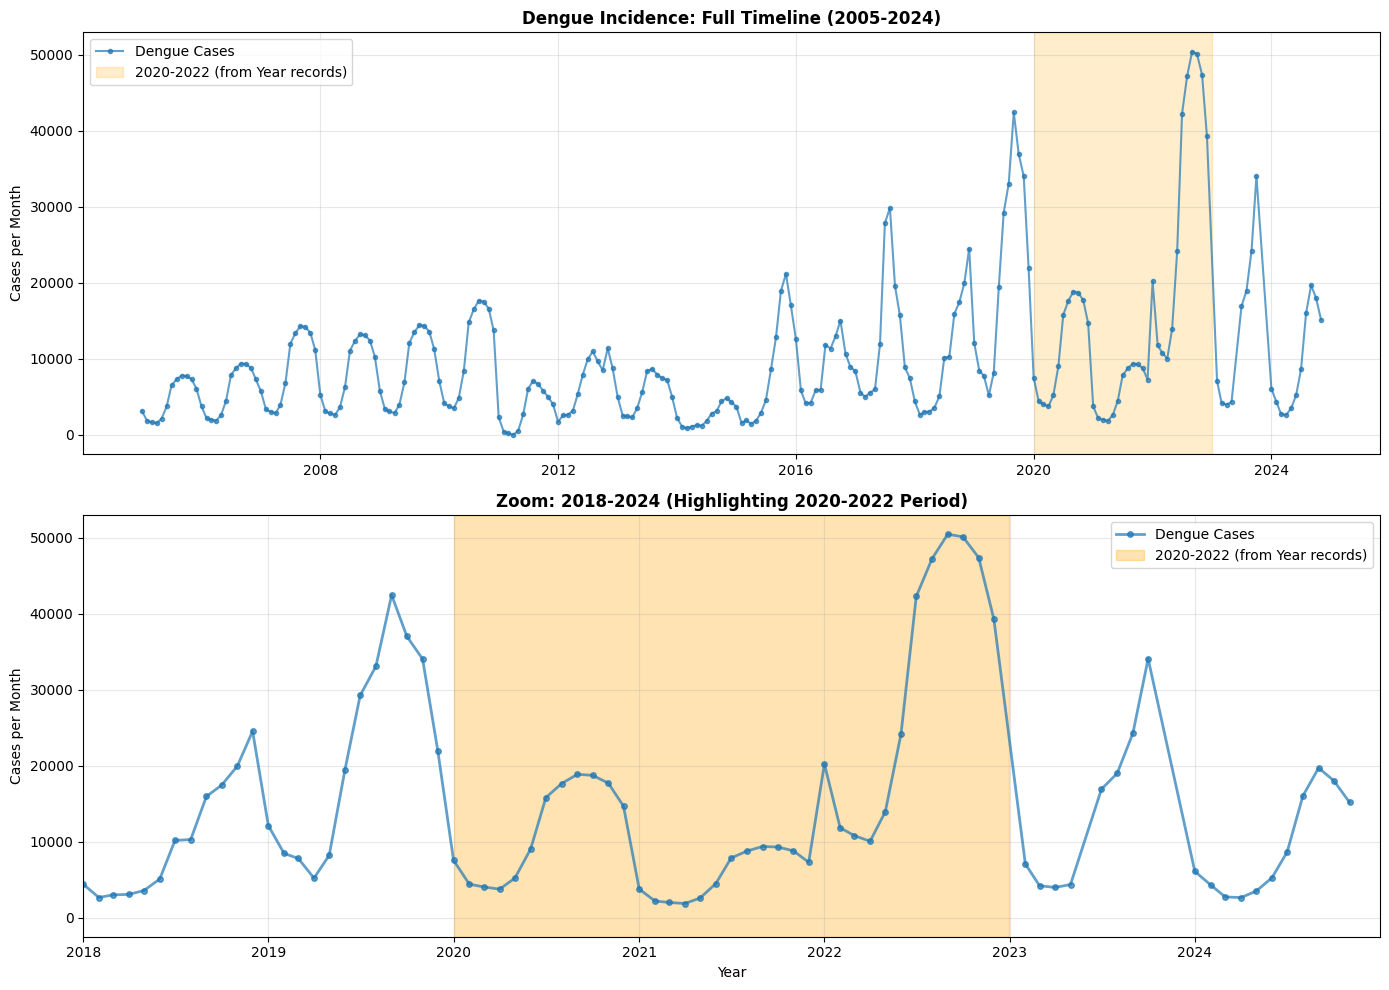

DATA COMPLETENESS SUMMARY

National level:
  Total records: 235
  Date range: 2005-01-01 00:00:00 to 2024-11-01 00:00:00
  Expected: 240 months (20 years)
  Completeness: 97.9%

⚠ Missing months (5):
  2023-01
  2023-06
  2023-11
  2023-12
  2024-12

Statistics by period:

Pre-COVID (2005-2019):
  Months: 180
  Mean: 8,431
  Median: 6,447
  Min: 19
  Max: 42,451
  Total: 1,517,514

COVID Period (2020-2022):
  Months: 36
  Mean: 15,930
  Median: 9,710
  Min: 1,866
  Max: 50,455
  Total: 573,467

Post-COVID (2023-2024):
  Months: 19
  Mean: 11,368
  Median: 7,074
  Min: 2,647
  Max: 34,074
  Total: 215,994


In [7]:
# --- Visualization: Check data completeness và 2020-2022 period
import matplotlib.pyplot as plt

national_data = combined_final[combined_final['adm_1_name'] == 'National'].copy()
national_data = national_data.set_index('YearMonth').sort_index()

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full timeline
axes[0].plot(national_data.index, national_data['dengue_total_month'], 
             'o-', label='Dengue Cases', markersize=3, alpha=0.7, linewidth=1.5)
axes[0].axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2022-12-31'), 
                alpha=0.2, color='orange', label='2020-2022 (from Year records)')
axes[0].set_title('Dengue Incidence: Full Timeline (2005-2024)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cases per Month')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoom vào 2018-2024
axes[1].plot(national_data.index, national_data['dengue_total_month'], 
             'o-', label='Dengue Cases', markersize=4, alpha=0.7, linewidth=2)
axes[1].axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2022-12-31'), 
                alpha=0.3, color='orange', label='2020-2022 (from Year records)')
axes[1].set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2024-12-31'))
axes[1].set_title('Zoom: 2018-2024 (Highlighting 2020-2022 Period)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cases per Month')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=" * 80)
print("DATA COMPLETENESS SUMMARY")
print("=" * 80)
print(f"\nNational level:")
print(f"  Total records: {len(national_data)}")
print(f"  Date range: {national_data.index.min()} to {national_data.index.max()}")
print(f"  Expected: 240 months (20 years)")
print(f"  Completeness: {len(national_data)/240*100:.1f}%")

# Check missing months
# Tạo date range expected (month-start dates để match với YearMonth format)
date_range_complete = pd.date_range(start='2005-01-01', end='2024-12-01', freq='MS')  # MS = Month Start

# Normalize cả hai về cùng format (year-month) để so sánh
# national_data.index đã là Timestamp (từ YearMonth column)
national_data_ym = set([(d.year, d.month) for d in national_data.index])
date_range_ym = set([(d.year, d.month) for d in date_range_complete])

# Tìm missing months (dựa trên year-month, không phải exact date)
missing_ym = sorted([(y, m) for (y, m) in date_range_ym if (y, m) not in national_data_ym])
missing_months = [pd.Timestamp(year=y, month=m, day=1) for y, m in missing_ym]

if len(missing_months) > 0:
    print(f"\n⚠ Missing months ({len(missing_months)}):")
    for month in missing_months[:10]:  # Show first 10
        print(f"  {month.strftime('%Y-%m')}")
    if len(missing_months) > 10:
        print(f"  ... and {len(missing_months) - 10} more")
else:
    print(f"\n✓ No missing months - data is complete!")

# Statistics by period
print(f"\nStatistics by period:")
periods = {
    'Pre-COVID (2005-2019)': (national_data.index < '2020-01-01'),
    'COVID Period (2020-2022)': ((national_data.index >= '2020-01-01') & (national_data.index <= '2022-12-31')),
    'Post-COVID (2023-2024)': (national_data.index > '2022-12-31')
}

for period_name, mask in periods.items():
    period_data = national_data[mask]
    if len(period_data) > 0:
        print(f"\n{period_name}:")
        print(f"  Months: {len(period_data)}")
        print(f"  Mean: {period_data['dengue_total_month'].mean():,.0f}")
        print(f"  Median: {period_data['dengue_total_month'].median():,.0f}")
        print(f"  Min: {period_data['dengue_total_month'].min():,.0f}")
        print(f"  Max: {period_data['dengue_total_month'].max():,.0f}")
        print(f"  Total: {period_data['dengue_total_month'].sum():,.0f}")

print("=" * 80)


In [8]:
combined_final.describe(include='all')


,adm_1_name,Year,Month,YearMonth,dengue_total_month
count,4807,4807.000000,4807.000000,4807,4807.000000
unique,65,NaN,NaN,NaN,NaN
top,National,NaN,NaN,NaN,NaN
freq,235,NaN,NaN,NaN,NaN
mean,NaN,2007.821926,6.498024,2008-04-11 23:51:36.733929728,596.615561
min,NaN,2005.000000,1.000000,2005-01-01 00:00:00,0.000000
25%,NaN,2006.000000,3.500000,2006-07-01 00:00:00,0.000000
50%,NaN,2008.000000,6.000000,2008-01-01 00:00:00,12.000000
75%,NaN,2009.000000,9.000000,2009-08-01 00:00:00,152.000000
max,NaN,2024.000000,12.000000,2024-11-01 00:00:00,50454.532126
